# Objective:
- Converting `netCDF => csv file => GeoJSON => Geotiff`
- First, we need to convert netcdf file to CSV format, then convert the CSV file to JSON (GeoJSON) which then will be converted to GeoTiff file

In [1]:
from osgeo import gdal
from osgeo import ogr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import netCDF4 as nc

# converting the datetime format
from datetime import datetime

# NOTE: Library `GDAL` required installation 
- `pip install gdal`
- if error follow instructions: https://www.youtube.com/watch?v=8iCWUp7WaTk&list=PLVvd_IdJOr_d4uVUmr_wWTUN_bJiYFxtT&index=1&t=51s

## Converting OCO2 NetCDF single file to CSV file


In [2]:
# DATE time function
def conv_date(d):
    return datetime.strptime(str(d), '%Y%m%d%H%M%S%f')

In [3]:
# FUNCTION to convert data
def convHdf(path_file, n=0):

    data= nc.Dataset(path_file)

    # get the HDF data and convert to CSV
    df_xco2= pd.DataFrame()

    df_xco2['Xco2']= data.variables['xco2'][:]
    df_xco2['Latitude']= data.variables['latitude'][:]
    df_xco2['Longitude']= data.variables['longitude'][:] 
    df_xco2['quality_flag']= data.variables['xco2_quality_flag'][:] 
    
    # Date
    df_xco2['DateTime']= data.variables['sounding_id'][:]
    
    #Convert soundingID to datetime format
    df_xco2['DateTime']= df_xco2['DateTime'].apply(conv_date)
    df_xco2['DateTime']= pd.to_datetime(df_xco2['DateTime'])
    
    # YEAR and month column
    df_xco2['Year']= df_xco2['DateTime'].dt.year
    df_xco2['Month']= df_xco2['DateTime'].dt.month
    df_xco2['Day']= df_xco2['DateTime'].dt.day
    
    # Refine the ENTIRE dataframe by GOOD quality_flag->0
    # NOTE: REDUCES the size of the file
    df_xco2= df_xco2[df_xco2['quality_flag'] == 0]   
    
   
    date= str(data.variables['sounding_id'][0])      
    
    # create a CSV and store on new folder: csv_files
    df_xco2.to_csv('oco2_xco2_'+ date+'_.csv', index= False)

### File path:
- locate the netcdf file

In [4]:
path_file= 'oco2_LtCO2_200404_B10206Ar_210513195718s.nc4'

### Check the txt file on same path
### Convert the netCdf file to CSV

In [6]:
# call the function and pass the file path
convHdf(path_file)

In [7]:
df_2019= pd.read_csv('oco2_xco2_2020040400164907_.csv')

In [8]:
df_2019.head(4)

,Xco2,Latitude,Longitude,quality_flag,DateTime,Year,Month,Day
0,411.90454,-45.501717,-155.43155,0,2020-04-04 00:17:41.080,2020,4,4
1,410.20260,-45.486874,-155.26593,0,2020-04-04 00:17:41.710,2020,4,4
2,409.77330,-45.484360,-155.29066,0,2020-04-04 00:17:41.720,2020,4,4
3,410.43118,-45.465855,-155.44122,0,2020-04-04 00:17:41.780,2020,4,4


## Next OBJ:
- Specific folders for different file formats
- Using command script to transform 'CSV' file format to 'JSON'
- Using JSON file format to Geotiff

## 1. Converting Files:
- From CSV to geoJSON format using 'OGR'
- <b>“POSSIBLE_NAMES”</b> : options tell OGR which fields are used for the coordinate values. 
- <b>"a_srs"</b> : refers to the source file map projection. 
- <b>"EPSG:4326"</b> : is the standard equirectangular map projection.

## create new directory to store JSON file

In [9]:
if not os.path.exists('json_format'):
    os.makedirs('json_format')
else:
    print("Directory exists!")

In [10]:
### PARAMETERS:

* Destination:
* Source: csv file

In [11]:
!ogr2ogr -oo X_POSSIBLE_NAMES=Longitude -oo Y_POSSIBLE_NAMES=Latitude -a_srs "EPSG:4326" json_format/oco2_2020.json oco2_xco2_2020040400164907_.csv

ERROR 1: PROJ: proj_create_from_database: C:\Users\sagarl\Anaconda3\Library\share\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR 1: Failed to process SRS definition: EPSG:4326


* <b>Output:</b> creates a folder of GeoJSON files (4 files total) which will be used to create a tif file

## 2. Convert the GeoJSON file to Geotiff
- <b>‘-a’</b>: refers to the field name. We use ‘-a_nodata’ to give it a nodata value of 0. 
- <b>‘-ts’</b> : refers to the target size

### NOTE 
- Here, in this example we use (-ts 512 256) for small for quick visualization. 
- Ideally, you’ll want to use the native extents and footprint sizes for each measurement, but that gets complicated


In [ ]:
## Save JSON file on the path:
!mkdir tif_format

In [ ]:
# !gdal_rasterize -a Xco2 -a_nodata 0 -ts 512 256 json_format/oco2_2020.json tif_format/oco2_2020.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdal_rasterize -a Xco2 -a_nodata 0 -ts 712 356 json_format/oco2_2020.json tif_format/oco2_2020.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


# 3. PNG file with color range: 

In [ ]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0AD2-78A8

 Directory of C:\Users\sagarl\JPL_Project\year_round\geotiff_conversion\Converting_JSON_to_geotiff

09/15/2022  02:06 PM    <DIR>          .
09/15/2022  02:06 PM    <DIR>          ..
09/15/2022  02:00 PM    <DIR>          .ipynb_checkpoints
01/06/2022  06:56 PM                37 colormap.txt
09/15/2022  02:06 PM    <DIR>          json_format
07/21/2021  05:45 PM        64,424,455 oco2_LtCO2_200404_B10206Ar_210513195718s.nc4
09/15/2022  02:06 PM         6,257,473 oco2_xco2_2020040400164907_.csv
09/15/2022  02:02 PM            31,993 open_geotiff_file.ipynb
09/15/2022  02:06 PM    <DIR>          tif_format
               4 File(s)     70,713,958 bytes
               5 Dir(s)  42,817,507,328 bytes free


#### Instructions:
* Locate tif file, colormap.txt file and destination

In [ ]:
if not os.path.exists('color_tif_file'):
    os.makedirs('color_tif_file')
else:
    print("Directory exists!")

Directory exists


In [ ]:
!gdaldem color-relief -alpha tif_format/oco2_2020.tif colormap.txt color_tif_file/oco2_2020_color.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


### 4. Finally, translating to PNG format
- If you want to produce a colored PNG output, you can do that in a few steps. - (colormap.txt): 
    - First, generate a txt colormap. 
    - Then create a colored TIFF file with a transparent alpha channel:

In [ ]:
if not os.path.exists('color_PNG_FILE'):
    os.makedirs('color_PNG_FILE')
else:
    print("Directory exists")

Directory exists


In [ ]:
!gdal_translate -of PNG -co "WORLDFILE=YES" color_tif_file/oco2_2020_color.tif color_PNG_FILE/oco2_2020_PNG.png

Input file size is 712, 356
0...10...20...30...40...50...60...70...80...90...100 - done.


# TESTING

In [ ]:
dataset_a= gdal.Open('color_tif_file/oco2_2020_color.tif', gdal.GA_ReadOnly)

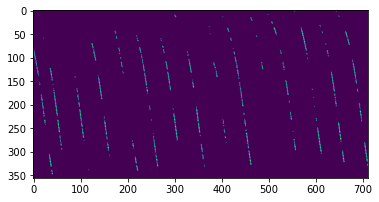

In [ ]:
band= dataset_a.GetRasterBand(4)

arr= band.ReadAsArray()
plt.imshow(arr)